In [1]:
from settings import s, e
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import pickle

from IPython.display import clear_output, display, update_display
import matplotlib.pyplot as plt


from simple import Game, get_x

from agent_code.tensor_agent.agent import TensorAgent
from agent_code.tensor_agent.hyperparameters import hp
from agent_code.tensor_agent.X import RelativeX2 as game_state_X

clear_output()

In [4]:
class Game:
    def __init__(self, coins, agents):
        self.shape = coins.shape
        self.agents = agents
        self.coins = coins
        self.steps = 0
        self.terminated = False
    
    @staticmethod
    def create_arena(shape, agent_names, coin_count=3):
        coins = np.zeros(shape)
        xs = np.random.choice(shape[0], coin_count)
        ys = np.random.choice(shape[1], coin_count)
        
        coins[xs, ys] = 1
        
        
        # Distribute starting positions
        xs = np.random.choice(shape[0], len(agent_names))
        ys = np.random.choice(shape[1], len(agent_names))
        agents = []
        for name in agent_names:
            x, y = np.random.choice(shape[0]), np.random.choice(shape[1])
            agents.append((x, y, name, 1, 0))
        
        return [coins, agents]
    
    def step(self, agent_actions, permutation=None):
        self.steps += 1

        if permutation is None:
            permutation = np.random.permutation(len(self.agents))

        step_score = {n: 0 for _,_,n,_,_ in self.agents}

        for j in range(len(self.agents)):
            agent = self.agents[permutation[j]]
            x, y, name, bombs_left, score = agent
            action = agent_actions[name]
            
            if action == 'DOWN' and self.tile_is_free(x, y+1):
                y += 1
            if action == 'UP' and self.tile_is_free(x, y-1):
                y -= 1
            if action == 'RIGHT' and self.tile_is_free(x+1, y):
                x += 1
            if action == 'LEFT' and self.tile_is_free(x-1, y):
                x -= 1
            
            self.agents[permutation[j]] = (x, y, name, bombs_left, score)
        
        
        for j in range(len(self.agents)):
            x, y, name, bombs_left, score = self.agents[j]
            if self.coins[x,y]==1:
                step_score[name]+=s.reward_coin
            self.coins[x,y]=0
        
        if np.all(self.coins == 0) or len(self.agents) == 0 or self.steps >= 40:
            self.terminated = True
        
        return step_score
    
    def get_X(self, x, y):
        X = np.zeros((self.shape[0] * 2 - 1, self.shape[1] * 2 - 1, 1))
        X[self.shape[0]-1-x:self.shape[0]*2-1-x, self.shape[1]-1-y:self.shape[1]*2-1-y, 0] = self.coins
        return X
        
    def tile_is_free(self, x, y):
        ax, ay = self.shape
        if x < 0 or x >= ax or y < 0 or y >= ay:
            return False
        return True
    

In [29]:
hp.buffer_size = 400
hp.target_network_period = 100
hp.epsilon = 0.4

In [30]:
from agent_code.tensor_agent.model import FullModel
choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
D = len(choices)
arena_shape = (4, 4)
input_shape = (arena_shape[0]*2-1, arena_shape[1]*2-1, 1)

K.clear_session()
model = FullModel(input_shape, D)

grads = tf.gradients(model.t_out, model.input_ph)

agents = {
    'tensor_agent': TensorAgent(input_shape, D, weights=None, model=model) # alt: weights='tensor_agent-model.h5'
}
train = {a: False for a in agents}
clear_output()

In [31]:

def get_valid_actions(x, y, game):
    # choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
    valid = np.ones((6))
    if not game.tile_is_free(x, y-1):
        valid[2] = 0 # UP invalid
    if not game.tile_is_free(x, y+1):
        valid[3] = 0 # DOWN invalid
    if not game.tile_is_free(x-1, y):
        valid[1] = 0 # LEFT invalid
    if not game.tile_is_free(x+1, y):
        valid[0] = 0 # RIGHT invalid

    valid[4] = 0
    valid[5] = 0
    return valid

In [32]:
d = display(f'Starting...', display_id='progress')

n_steps = 40000
game = None

train['tensor_agent'] = True

for step in range(n_steps):
    if game is None:
        game = Game(*Game.create_arena(arena_shape, agents.keys()))

    actions = {}
    Xs = {}
    for agent in game.agents:
        x, y, name, _, _ = agent
        
        Xs[name] = game.get_X(x, y)
        valid_actions = get_valid_actions(x, y, game)
        actions[name] = agents[name].act(Xs[name], train=train[name], valid_actions=valid_actions)
    
    actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
    rewards = game.step(actions_as_string)

    for _, _, name, _, _ in game.agents:
        if train[name]:
            agents[name].reward_update([Xs[name], actions[name], rewards[name]-0.1])
    
    if game.terminated:
        for name, a in agents.items():
            a.end_of_episode(save='tensor_agent-model.h5') # alt: save=None
        
        d.update(f'Step: {step+1}/{n_steps}')
        
        game = None

d.update(f'Complete')

'Complete'

End of episode. Steps: 40. Trained: 0
End of episode. Steps: 80. Trained: 0
End of episode. Steps: 120. Trained: 5
End of episode. Steps: 159. Trained: 14
End of episode. Steps: 199. Trained: 24
End of episode. Steps: 226. Trained: 31
End of episode. Steps: 266. Trained: 41
End of episode. Steps: 306. Trained: 51
End of episode. Steps: 346. Trained: 61
End of episode. Steps: 386. Trained: 71
End of episode. Steps: 426. Trained: 81
End of episode. Steps: 466. Trained: 91
End of episode. Steps: 506. Trained: 101
End of episode. Steps: 514. Trained: 103
End of episode. Steps: 524. Trained: 106
End of episode. Steps: 564. Trained: 116
End of episode. Steps: 604. Trained: 126
End of episode. Steps: 625. Trained: 131
End of episode. Steps: 665. Trained: 141
End of episode. Steps: 705. Trained: 151
End of episode. Steps: 731. Trained: 157
End of episode. Steps: 771. Trained: 167
End of episode. Steps: 808. Trained: 177
End of episode. Steps: 848. Trained: 187
End of episode. Steps: 888. Train

End of episode. Steps: 7423. Trained: 1830
End of episode. Steps: 7463. Trained: 1840
End of episode. Steps: 7503. Trained: 1850
End of episode. Steps: 7543. Trained: 1860
End of episode. Steps: 7583. Trained: 1870
End of episode. Steps: 7623. Trained: 1880
End of episode. Steps: 7663. Trained: 1890
End of episode. Steps: 7703. Trained: 1900
End of episode. Steps: 7743. Trained: 1910
End of episode. Steps: 7783. Trained: 1920
End of episode. Steps: 7823. Trained: 1930
End of episode. Steps: 7863. Trained: 1940
End of episode. Steps: 7903. Trained: 1950
End of episode. Steps: 7943. Trained: 1960
End of episode. Steps: 7950. Trained: 1962
End of episode. Steps: 7990. Trained: 1972
End of episode. Steps: 8010. Trained: 1977
End of episode. Steps: 8050. Trained: 1987
End of episode. Steps: 8090. Trained: 1997
End of episode. Steps: 8119. Trained: 2004
End of episode. Steps: 8159. Trained: 2014
End of episode. Steps: 8199. Trained: 2024
End of episode. Steps: 8239. Trained: 2034
End of epis

End of episode. Steps: 14446. Trained: 3586
End of episode. Steps: 14486. Trained: 3596
End of episode. Steps: 14526. Trained: 3606
End of episode. Steps: 14566. Trained: 3616
End of episode. Steps: 14606. Trained: 3626
End of episode. Steps: 14646. Trained: 3636
End of episode. Steps: 14686. Trained: 3646
End of episode. Steps: 14726. Trained: 3656
End of episode. Steps: 14766. Trained: 3666
End of episode. Steps: 14806. Trained: 3676
End of episode. Steps: 14846. Trained: 3686
End of episode. Steps: 14886. Trained: 3696
End of episode. Steps: 14905. Trained: 3701
End of episode. Steps: 14945. Trained: 3711
End of episode. Steps: 14985. Trained: 3721
End of episode. Steps: 15025. Trained: 3731
End of episode. Steps: 15065. Trained: 3741
End of episode. Steps: 15105. Trained: 3751
End of episode. Steps: 15145. Trained: 3761
End of episode. Steps: 15157. Trained: 3764
End of episode. Steps: 15197. Trained: 3774
End of episode. Steps: 15237. Trained: 3784
End of episode. Steps: 15277. Tr

End of episode. Steps: 21529. Trained: 5357
End of episode. Steps: 21569. Trained: 5367
End of episode. Steps: 21609. Trained: 5377
End of episode. Steps: 21649. Trained: 5387
End of episode. Steps: 21689. Trained: 5397
End of episode. Steps: 21729. Trained: 5407
End of episode. Steps: 21769. Trained: 5417
End of episode. Steps: 21809. Trained: 5427
End of episode. Steps: 21849. Trained: 5437
End of episode. Steps: 21889. Trained: 5447
End of episode. Steps: 21929. Trained: 5457
End of episode. Steps: 21969. Trained: 5467
End of episode. Steps: 22009. Trained: 5477
End of episode. Steps: 22049. Trained: 5487
End of episode. Steps: 22089. Trained: 5497
End of episode. Steps: 22100. Trained: 5500
End of episode. Steps: 22140. Trained: 5510
End of episode. Steps: 22180. Trained: 5520
End of episode. Steps: 22189. Trained: 5522
End of episode. Steps: 22229. Trained: 5532
End of episode. Steps: 22269. Trained: 5542
End of episode. Steps: 22309. Trained: 5552
End of episode. Steps: 22349. Tr

End of episode. Steps: 28346. Trained: 7061
End of episode. Steps: 28386. Trained: 7071
End of episode. Steps: 28426. Trained: 7081
End of episode. Steps: 28466. Trained: 7091
End of episode. Steps: 28506. Trained: 7101
End of episode. Steps: 28546. Trained: 7111
End of episode. Steps: 28586. Trained: 7121
End of episode. Steps: 28604. Trained: 7126
End of episode. Steps: 28644. Trained: 7136
End of episode. Steps: 28684. Trained: 7146
End of episode. Steps: 28724. Trained: 7156
End of episode. Steps: 28764. Trained: 7166
End of episode. Steps: 28804. Trained: 7176
End of episode. Steps: 28844. Trained: 7186
End of episode. Steps: 28884. Trained: 7196
End of episode. Steps: 28924. Trained: 7206
End of episode. Steps: 28964. Trained: 7216
End of episode. Steps: 29004. Trained: 7226
End of episode. Steps: 29044. Trained: 7236
End of episode. Steps: 29084. Trained: 7246
End of episode. Steps: 29124. Trained: 7256
End of episode. Steps: 29155. Trained: 7263
End of episode. Steps: 29195. Tr

End of episode. Steps: 35352. Trained: 8813
End of episode. Steps: 35392. Trained: 8823
End of episode. Steps: 35432. Trained: 8833
End of episode. Steps: 35464. Trained: 8841
End of episode. Steps: 35504. Trained: 8851
End of episode. Steps: 35535. Trained: 8858
End of episode. Steps: 35550. Trained: 8862
End of episode. Steps: 35590. Trained: 8872
End of episode. Steps: 35630. Trained: 8882
End of episode. Steps: 35670. Trained: 8892
End of episode. Steps: 35710. Trained: 8902
End of episode. Steps: 35750. Trained: 8912
End of episode. Steps: 35790. Trained: 8922
End of episode. Steps: 35830. Trained: 8932
End of episode. Steps: 35870. Trained: 8942
End of episode. Steps: 35910. Trained: 8952
End of episode. Steps: 35950. Trained: 8962
End of episode. Steps: 35990. Trained: 8972
End of episode. Steps: 36030. Trained: 8982
End of episode. Steps: 36070. Trained: 8992
End of episode. Steps: 36110. Trained: 9002
End of episode. Steps: 36150. Trained: 9012
End of episode. Steps: 36190. Tr

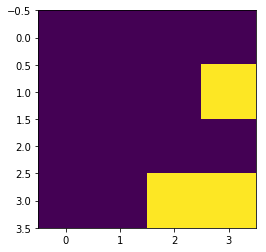

In [115]:
game = Game(*Game.create_arena(arena_shape, agents.keys()))
plt.imshow(game.coins)

3 1
[-0.24074677 -0.23336731 -0.04630946 -0.08356725 -0.19533911 -0.3493805 ]
[0.         1.11601317 1.30307102 1.26581323 0.         0.        ]
UP {'tensor_agent': 0}


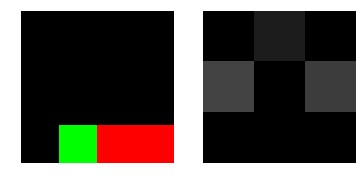

In [242]:
actions = {}
Xs = {}
for agent in game.agents:
    x, y, name, _, _ = agent

    Xs[name] = game.get_X(x, y)
    valid_actions = get_valid_actions(x, y, game)
    
    print(x, y)
    pred = agents[name].model.online.predict(np.array([Xs[name]]))[0]
    print(pred)
    if valid_actions is not None:
        pred = valid_actions * (pred - np.min(pred) + 1)

    print(pred)
    action_choice = np.argmax(pred)
            
    actions[name] = action_choice

actions_as_string = {n: choices[actions[n]] for n in actions.keys()}
#actions_as_string['tensor_agent'] = 'RIGHT'
rewards = game.step(actions_as_string)

print(actions_as_string['tensor_agent'], rewards)

#img = np.zeros((input_shape[0], input_shape[1], 3))
#img[:,:,0] = Xs['tensor_agent'][:,:,0]
#img[arena_shape[0]-1,arena_shape[1]-1,1] = 1

img = np.zeros((arena_shape[0], arena_shape[0], 3))
img[:,:,0] = game.coins
img[x,y,1] = 1


choices = ['RIGHT', 'LEFT', 'UP', 'DOWN', 'BOMB', 'WAIT']
choice_dict = {choices[i]: i for i in range(len(choices))}

a = np.zeros((3, 3))
a[2, 1] = pred[choice_dict['RIGHT']]
a[0, 1] = pred[choice_dict['LEFT']]
a[1, 0] = pred[choice_dict['UP']]
a[1, 2] = pred[choice_dict['DOWN']]
a[1, 1] = pred[choice_dict['WAIT']]
a[0, 0] = pred[choice_dict['BOMB']]

#a = np.exp(a) / np.sum(np.exp(a), axis=0)
a = np.log(a + 0.0001)
a[a == -np.inf] = 0

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.axis('off')
ax2.axis('off')
ax2.imshow(a, cmap='gray', vmin=0, vmax=1)
ax1.imshow(img)

In [206]:
game.agents[0]

(0, 1, 'tensor_agent', 1, 0)

In [8]:
pred, grd = K.get_session().run([model.t_out, grads], feed_dict={
            model.input_ph: np.array([Xs['tensor_agent']])
        })

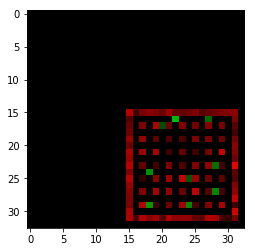

In [21]:
img0 = grd[0][0][:,:,0:1]
img0 = img0 - np.min(img0)
img0 = img0 / np.max(img0)

img1 = grd[0][0][:,:,1:2]
img1 = img1 - np.min(img1)
img1 = img1 / np.max(img1)

img5 = grd[0][0][:,:,5:6]
img5 = img5 - np.min(img5)
img5 = img5 / np.max(img5)

inp = Xs['tensor_agent'][:,:,[0,5,1]]
img = np.concatenate([img0, img5, img1], axis=2)


plt.imshow(img * inp)

In [6]:
class FrozenLake:
    def __init__(self, coins, agents):
        self.shape = coins.shape
        self.agents = agents
        self.coins = coins
        self.steps = 0
        self.terminated = False
    
    @staticmethod
    def create_arena(shape, agent_names):
        lake = np.zeros(shape)
        xs = np.random.choice(shape[0], 1)
        ys = np.random.choice(shape[1], 1)
        
        lake[xs, ys] = 1
        
        while np.min(lake) > -1:
            xs = np.random.choice(shape[0], 1)
            ys = np.random.choice(shape[1], 1)
            if lake[xs, ys] != 1:
                lake[xs, ys] = -1
        
        
        # Distribute starting positions
        xs = np.random.choice(shape[0], len(agent_names))
        ys = np.random.choice(shape[1], len(agent_names))
        agents = []
        for name in agent_names:
            x, y = np.random.choice(shape[0]), np.random.choice(shape[1])
            agents.append((x, y, name, 1, 0))
        
        return [lake, agents]
    
    def step(self, agent_actions, permutation=None):
        self.steps += 1

        if permutation is None:
            permutation = np.random.permutation(len(self.agents))

        step_score = {n: 0 for _,_,n,_,_ in self.agents}

        for j in range(len(self.agents)):
            agent = self.agents[permutation[j]]
            x, y, name, bombs_left, score = agent
            action = agent_actions[name]
            
            if action == 'DOWN' and self.tile_is_free(x, y+1):
                y += 1
            if action == 'UP' and self.tile_is_free(x, y-1):
                y -= 1
            if action == 'RIGHT' and self.tile_is_free(x+1, y):
                x += 1
            if action == 'LEFT' and self.tile_is_free(x-1, y):
                x -= 1
            
            self.agents[permutation[j]] = (x, y, name, bombs_left, score)
        
        
        for j in range(len(self.agents)):
            x, y, name, bombs_left, score = self.agents[j]
            if self.coins[x,y]==1:
                step_score[name]+=s.reward_coin
            self.coins[x,y]=0
        
        if np.all(self.coins == 0) or len(self.agents) == 0 or self.steps >= 40:
            self.terminated = True
        
        return step_score
    
    def get_X(self, x, y):
        X = np.zeros((self.shape[0] * 2 - 1, self.shape[1] * 2 - 1, 1))
        X[self.shape[0]-1-x:self.shape[0]*2-1-x, self.shape[1]-1-y:self.shape[1]*2-1-y, 0] = self.coins
        return X
        
    def tile_is_free(self, x, y):
        ax, ay = self.shape
        if x < 0 or x >= ax or y < 0 or y >= ay:
            return False
        return True
    